# Código de Procesamiento de Resultados (Práctica Especial - Detección de rayos cósmicos)

Autores: Brusco Agustín y Bruno Sivilotti

### Imports y formato

In [1]:
import os

import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.labelsize'] = 'large'

### Lectura de los resultados

In [9]:
video_folder = r'/home/agus/Documents/2022 1er Cuatrimestre/Laboratorio 4/Práctica Especial/Código y Datos/Grabaciones'
os.chdir(video_folder)
# No es necesario disponer de los videos para ejecutar este código, solo los resultados.
videos = ['bueno1506.mp4', 'bueno1515.mp4', 'bueno1603.mp4', 'bueno1608.mp4',
          'bueno1635.mp4', 'bueno1641.mp4', 'bueno1708.mp4', 'bueno1729.mp4']
Betas = []  # °
for v in videos:
    tag = v[:-4]
    os.chdir(video_folder + '/' + f'resultados_{tag}')
    Betas.append(np.load(f'BetaA_{tag}.npy'))  # °
    Betas.append(np.load(f'BetaM_{tag}.npy'))  # °
    os.chdir(video_folder)
# Array de todas las mediciones en una tira de datos:
beta_experimental = np.concatenate(Betas)*np.pi/180  # En radianes


# DataFrame de las mediciones catalogadas por video y método:
d = dict(hora=[], metodo=[], beta=beta_experimental)
i = 0
for vid in videos:
    time_str = vid[5:-4]
    hora = time_str[:2] + ':' + time_str[2:]
    for met in ['Semi-Automática', 'Manual']:
        for b in Betas[i]:
            d['hora'].append(hora)
            d['metodo'].append(met)
        i += 1
        
Mediciones = pd.DataFrame(d)
display(Mediciones)

,hora,metodo,beta
0,15:06,Semi-Automática,-0.124355
1,15:06,Semi-Automática,-0.785398
2,15:06,Semi-Automática,-0.110657
3,15:06,Semi-Automática,-1.107149
4,15:06,Semi-Automática,1.339706
...,...,...,...
529,17:29,Manual,1.428899
530,17:29,Manual,-1.205595
531,17:29,Manual,-0.404892
532,17:29,Manual,-0.588003


In [10]:
frac_area = [1/2, 0.9, 0.8, 0.8, None, 0.9, 0.8, 0.8]  # fracción del área de la cámara analizada (estimación).
A = 10e-2*20e-2  # m² : Área estimada de la base de la cámara de niebla.
T = 5*60  # s : duración de los videos en segundos.
F = []  # m⁻²·s⁻¹
for i, vid in enumerate(videos):
    if frac_area[i] is not None:
        N_obs = len(np.concatenate(Betas[2*i:2*i+2]))
        F.append(N_obs/(T*frac_area[i]*A))
f = np.mean(F)
df = np.std(F, ddof=1)

print(f'flujo estimado = ({f:.0f} ± {df:.0f}) m⁻²·s⁻¹')

flujo estimado = (16 ± 10) m⁻²·s⁻¹


### Generación de los pares de variables aleatorias mediante el método de Montecarlo:
Primero se generan `nf` pares de variables aleatorias $(\varphi, \theta)$ según:
$$P(\varphi,\theta) = I_0 \cos^2(\theta)\, \mathrm{d}\varphi\, \mathrm{d}\theta.$$
Luego, se aplica a los `nf` pares la función
$$\beta(\varphi, \theta) = \sin^{-1}\left[\frac{\cos(\varphi)\sin(\theta)}{\sqrt{1-\cos^2(\alpha)\cos^2(\theta)[\tan(\alpha)\tan(\theta)\sin(\varphi)-1]^2}}\right],$$
obteniendose así `nf` valores de la variable $\beta$.

In [2]:
def f(t):
    """Densidad de probabilidad asociada a la variable θ."""
    return 4/np.pi*np.cos(t)**2


def beta_func(phi, theta, alfa=60*np.pi/180):
    p_dot_x = np.cos(phi)*np.sin(theta)
    p_dot_p = 1-(np.cos(alfa)*np.cos(theta))**2*(np.tan(alfa)*np.tan(theta)*np.sin(phi)-1)**2
    return np.arcsin(p_dot_x / np.sqrt(p_dot_p))


rng = np.random.default_rng(23)
n = 0
nf = 1_000_000  # cantidad de valores a generar
# Para la variable phi:
phi = rng.uniform(0, 2*np.pi, nf)
# Para la variable theta:
theta = np.zeros(nf)
while n < nf: 
    x = rng.random(2)
    u = x[0]*(np.pi/2)  # Mapeo a 0-pi/2
    v = x[1]*4/np.pi  # Máx de mi distibución f(0) = 4/pi
    if v < f(u):
        theta[n] = u        
        n += 1
# Para la variable beta:
alfa = 60  # ° : angulo del celular con la horizontal
alfa = alfa*np.pi/180  # paso a radianes
# Calculamos el ángulo que ve el celular en función de los angulos reales theta y phi
beta_montecarlo = beta_func(phi, theta, alfa)

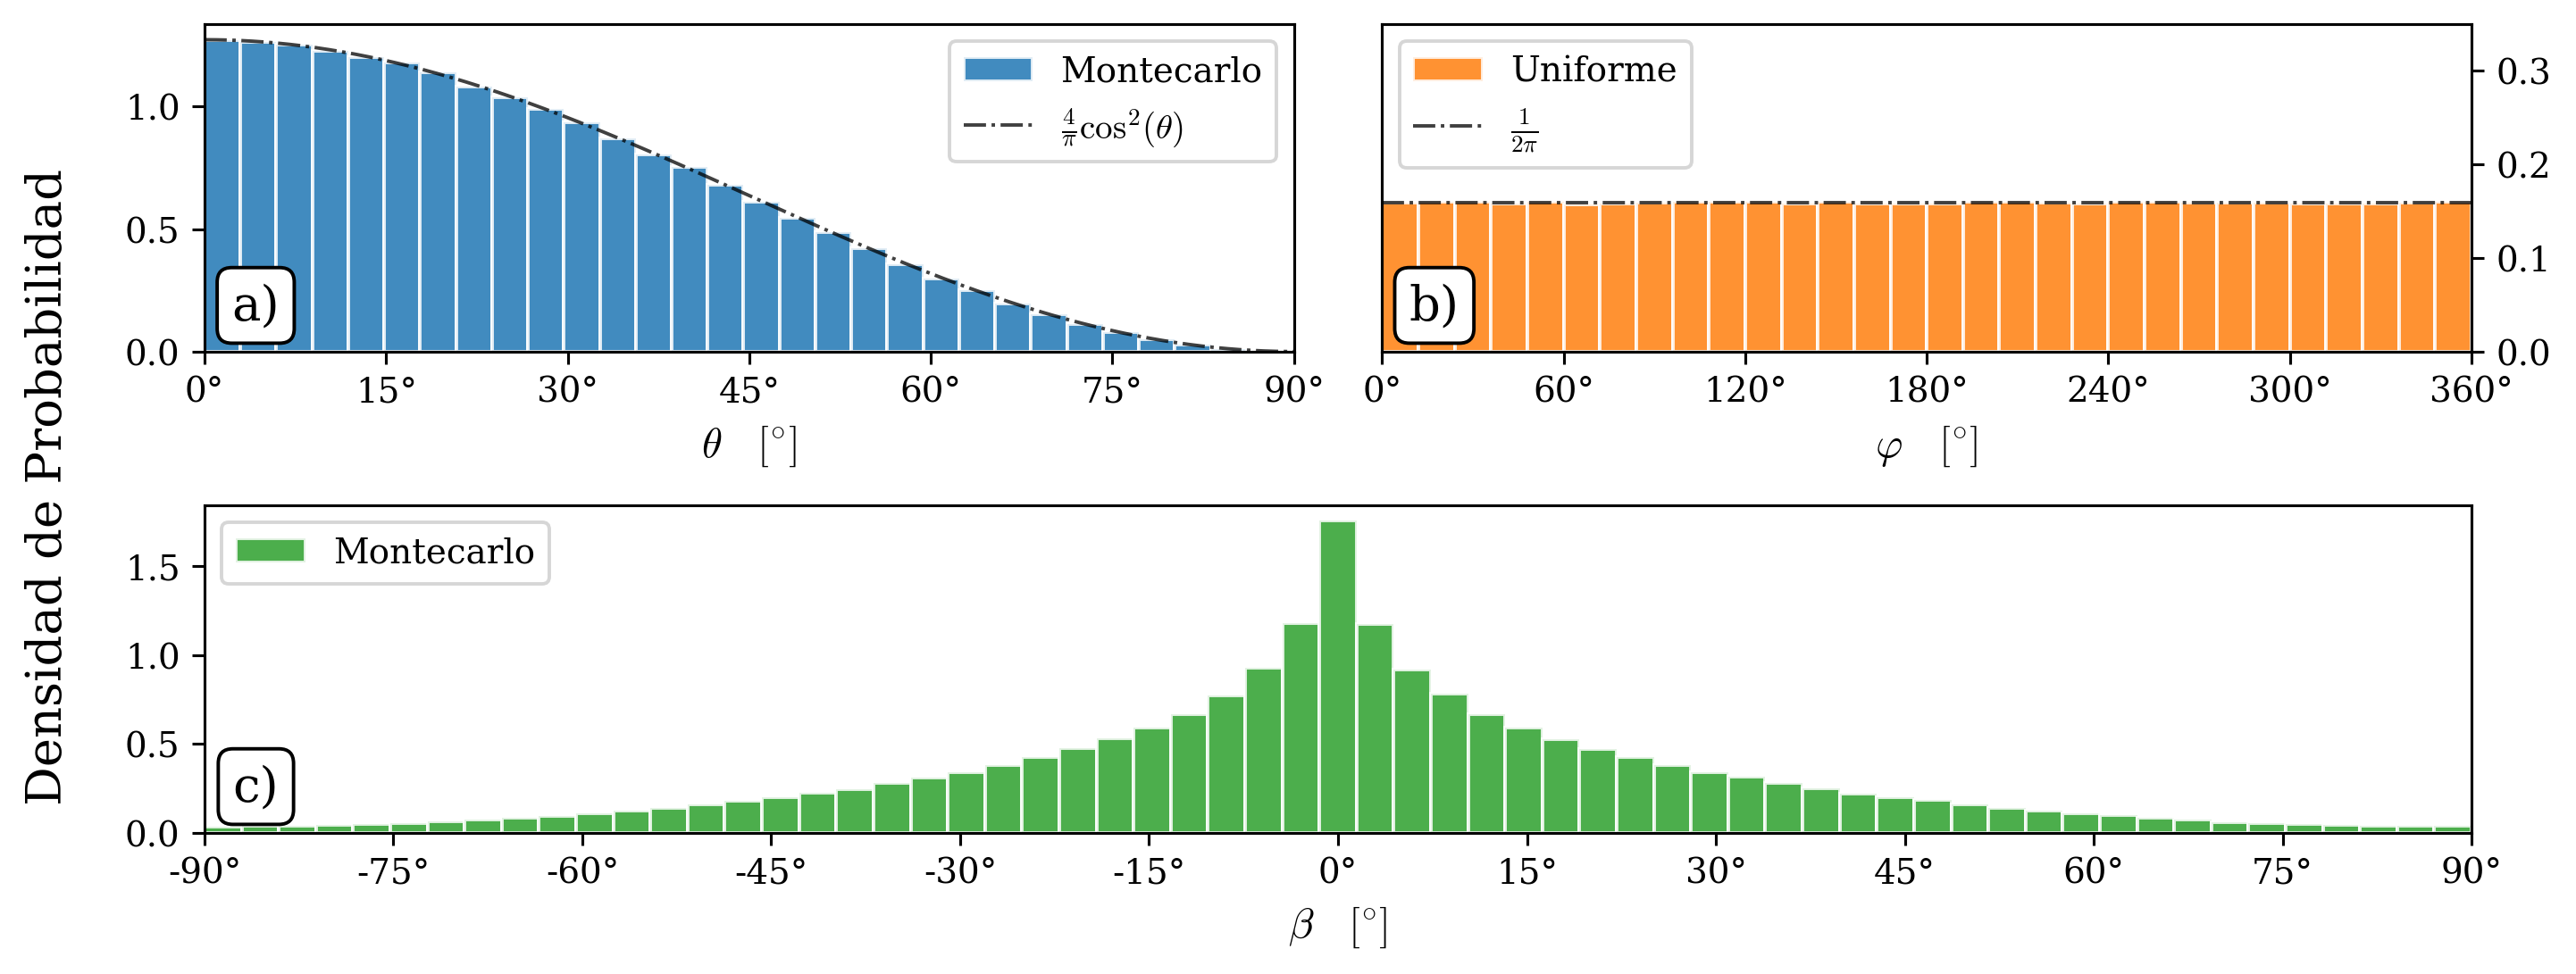

In [7]:
fig = plt.figure(figsize=(10, 4.), dpi=140, tight_layout=True)

axs = plt.subplot(221), plt.subplot(222), plt.subplot(212)

t_dense = np.linspace(0, np.pi/2, 1000)
axs[0].hist(theta, density=True, label=r'Montecarlo', bins=30, edgecolor='w',
            linewidth=1, alpha=0.85)
axs[0].plot(t_dense, f(t_dense), 'k', ls='-.', lw=1., alpha=0.75,
         label=r'$\frac{4}{\pi}\cos^2(\theta)$',)
axs[0].legend()
axs[0].text(0.025, 0.1, s='a)', fontsize=14, transform=axs[0].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
axs[0].set_xticks([i*np.pi/12 for i in range(0, 7)])
axs[0].set_xticklabels([f'{i*15}°' for i in range(0, 7)])
axs[0].set_xlim(0, np.pi/2)
axs[0].set_xlabel(r'$\theta \quad \mathrm{[^{\circ}]}$')

axs[1].hist(phi, color='C1', density=True, label=r'Uniforme', bins=30, edgecolor='w',
            linewidth=1, alpha=0.85)
axs[1].axhline(1/(2*np.pi), c='k', ls='-.', lw=1., label=r'$\frac{1}{2\pi}$', alpha=0.75)
axs[1].legend(loc='upper left')
axs[1].text(0.025, 0.1, s='b)', fontsize=14, transform=axs[1].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
axs[1].set_xticks([i*np.pi/3 for i in range(0, 7)])
axs[1].set_xticklabels([f'{i*60}°' for i in range(0, 7)])
axs[1].set_xlim(0, 2*np.pi)
axs[1].set_ylim(0, 0.35)
axs[1].set_xlabel(r'$\varphi \quad \mathrm{[^{\circ}]}$')
axs[1].yaxis.tick_right()

axs[2].hist(beta_montecarlo, color='C2', density=True,
        label=rf'Montecarlo',
        cumulative=False, bins=61, edgecolor='w', linewidth=1, alpha=0.85)
axs[2].legend(loc='upper left')
axs[2].text(0.0125, 0.1, s='c)', fontsize=14, transform=axs[2].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
axs[2].set_xticks([i*np.pi/12 for i in range(-6, 7)])
axs[2].set_xticklabels([f'{i*15}°' for i in range(-6, 7)])
axs[2].set_xlim(-np.pi/2, np.pi/2)
axs[2].set_xlabel(r'$\beta \quad \mathrm{[^{\circ}]}$')

fig.text(-0.025, 0.5, 'Densidad de Probabilidad', va='center', rotation='vertical',
         size=14)
plt.show()

### Comparación entre las mediciones y el método de Montecarlo

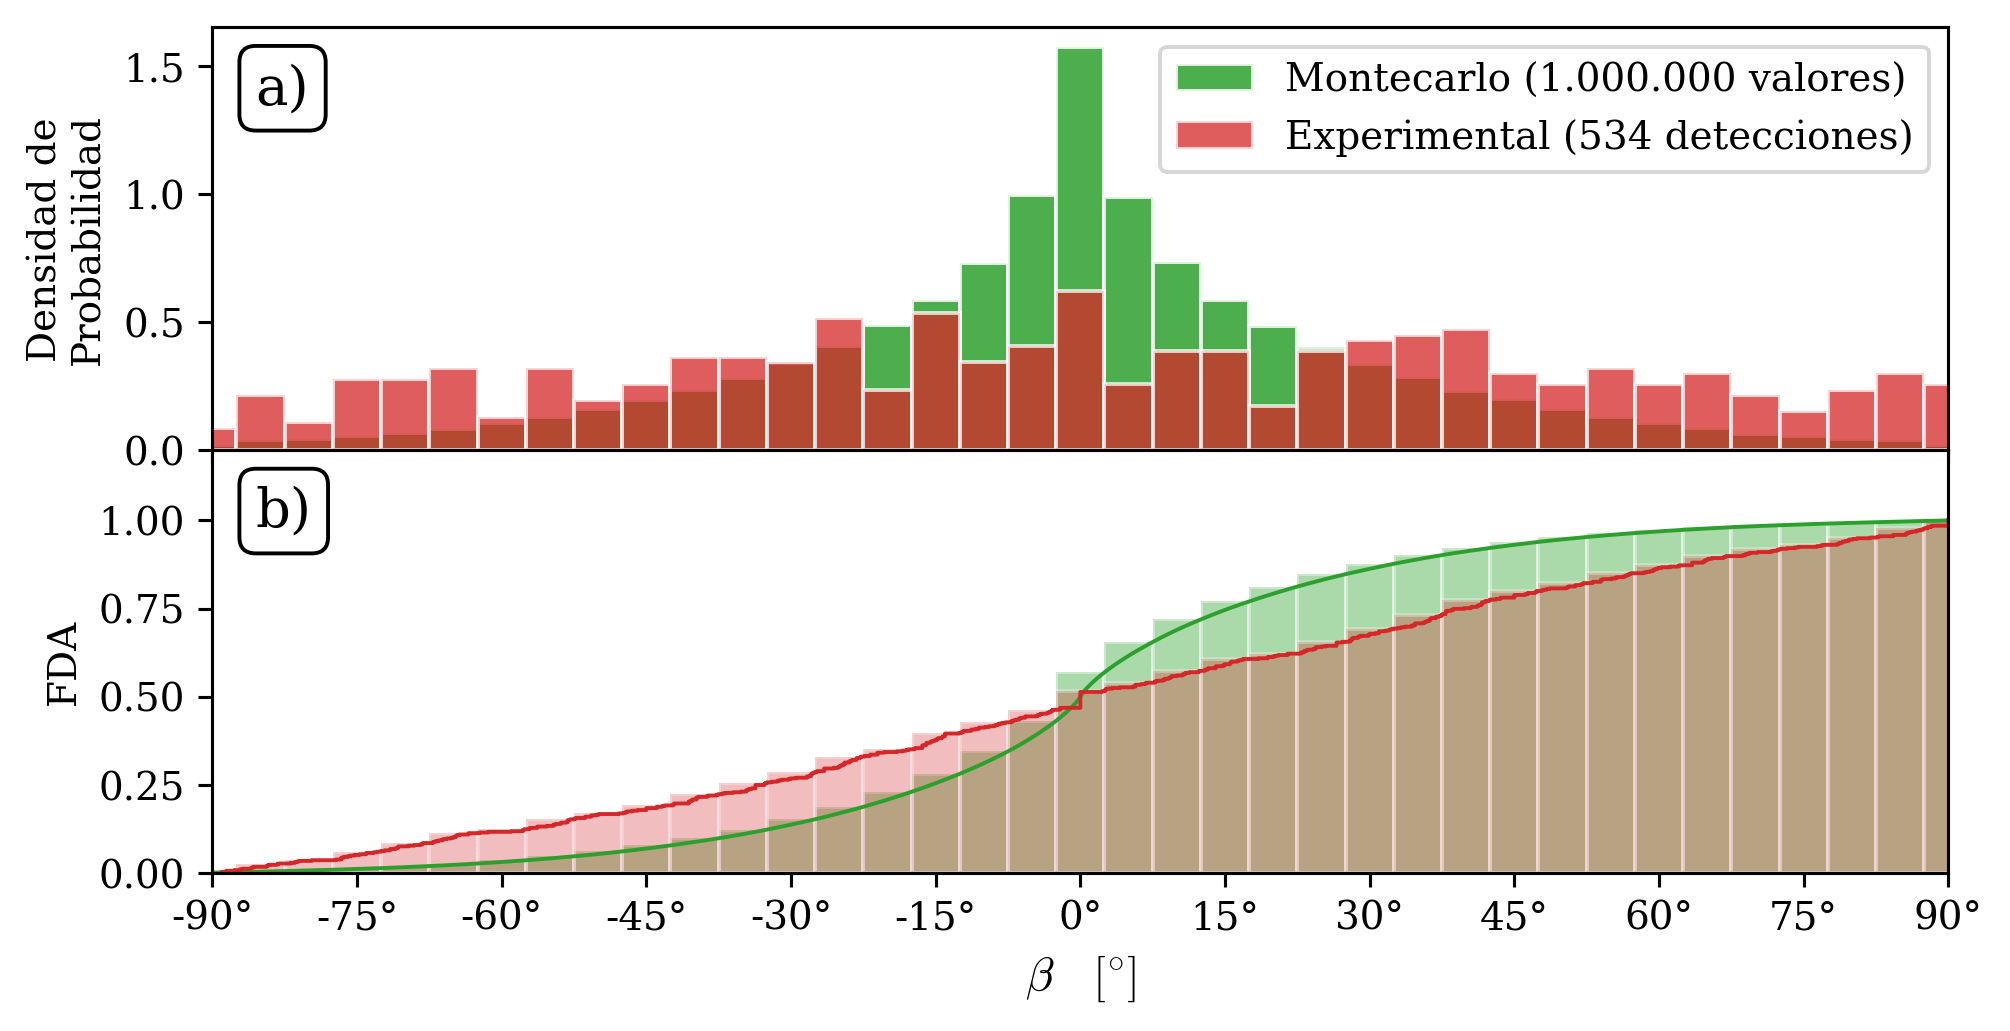

Valores centrales:


,media,mediana,moda
Montecarlo,0.000553,-1.728456e-07,"([-1.570766472222685], [1])"
Experimental,0.050584,0.000000e+00,"([0.0], [24])"


Resultados del test: KstestResult(statistic=0.19712524344569282, pvalue=1.1707109418215732e-18)


In [12]:
beta_sorted_montecarlo = np.sort(beta_montecarlo)
cdf_m = np.cumsum(beta_sorted_montecarlo**0)/beta_montecarlo.size

beta_sorted_experimental = np.sort(beta_experimental)
cdf_e = np.cumsum(beta_sorted_experimental**0)/beta_experimental.size

delta = 5*np.pi/180
edges = np.arange(np.pi/2, -np.pi/2 - 2*delta, -delta)[::-1] + delta/2
# Distribución
fig, axs = plt.subplots(2, 1, figsize=(8, 4.), dpi=140, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].hist(beta_montecarlo, bins=edges, density=True, cumulative=False,
            color='C2', edgecolor='w', alpha=0.85,
            label=rf'Montecarlo (1.000.000 valores)',)
axs[0].hist(beta_experimental, bins=edges, density=True, cumulative=False,
            color='C3', edgecolor='w', alpha=0.75,
            label=rf'Experimental ({beta_experimental.size} detecciones)',)
axs[0].legend(loc='upper right')
axs[0].text(0.025, 0.82, s='a)', fontsize=14, transform=axs[0].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
# axs[0].set_xticks([i*np.pi/12 for i in range(-6, 7)])
# axs[0].set_xticklabels([f'{i*15}°' for i in range(-6, 7)])
# axs[0].set_xlim(-np.pi/2, np.pi/2)
axs[0].set_ylabel('Densidad de\nProbabilidad', fontsize=10)


# Acumulativa
axs[1].hist(beta_montecarlo, bins=edges, density=True, cumulative=True,
            color='C2', edgecolor='w', alpha=0.4)
axs[1].hist(beta_experimental, bins=edges, density=True, cumulative=True,
            color='C3', edgecolor='w', alpha=0.3)

plt.plot(beta_sorted_montecarlo, cdf_m, 'C2-', lw=1, drawstyle='steps-post')
plt.plot(beta_sorted_experimental, cdf_e, 'C3-', lw=1, drawstyle='steps-post')
# axs[1].legend(loc='upper left')
axs[1].text(0.025, 0.82, s='b)', fontsize=14, transform=axs[1].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
axs[1].set_xticks([i*np.pi/12 for i in range(-6, 7)])
axs[1].set_xticklabels([f'{i*15}°' for i in range(-6, 7)])
axs[1].set_xlim(-np.pi/2, np.pi/2)
axs[1].set_xlabel(r'$\beta \quad \mathrm{[^{\circ}]}$')
axs[1].set_ylim(top=1.2)
axs[1].set_ylabel('FDA', fontsize=10)

plt.show()

print('Valores centrales:')
c_vals = dict(media=[np.mean(beta_montecarlo), np.mean(beta_experimental)],
              mediana=[np.median(beta_montecarlo), np.median(beta_experimental)],
              moda=[stats.mode(beta_montecarlo), stats.mode(beta_experimental)],)
display(pd.DataFrame(c_vals, index=['Montecarlo', 'Experimental']))
print('Resultados del test:', stats.ks_2samp(beta_experimental, beta_montecarlo))

## Meta análisis de las mediciones

### Comparación mediciones Bruno y Agustín

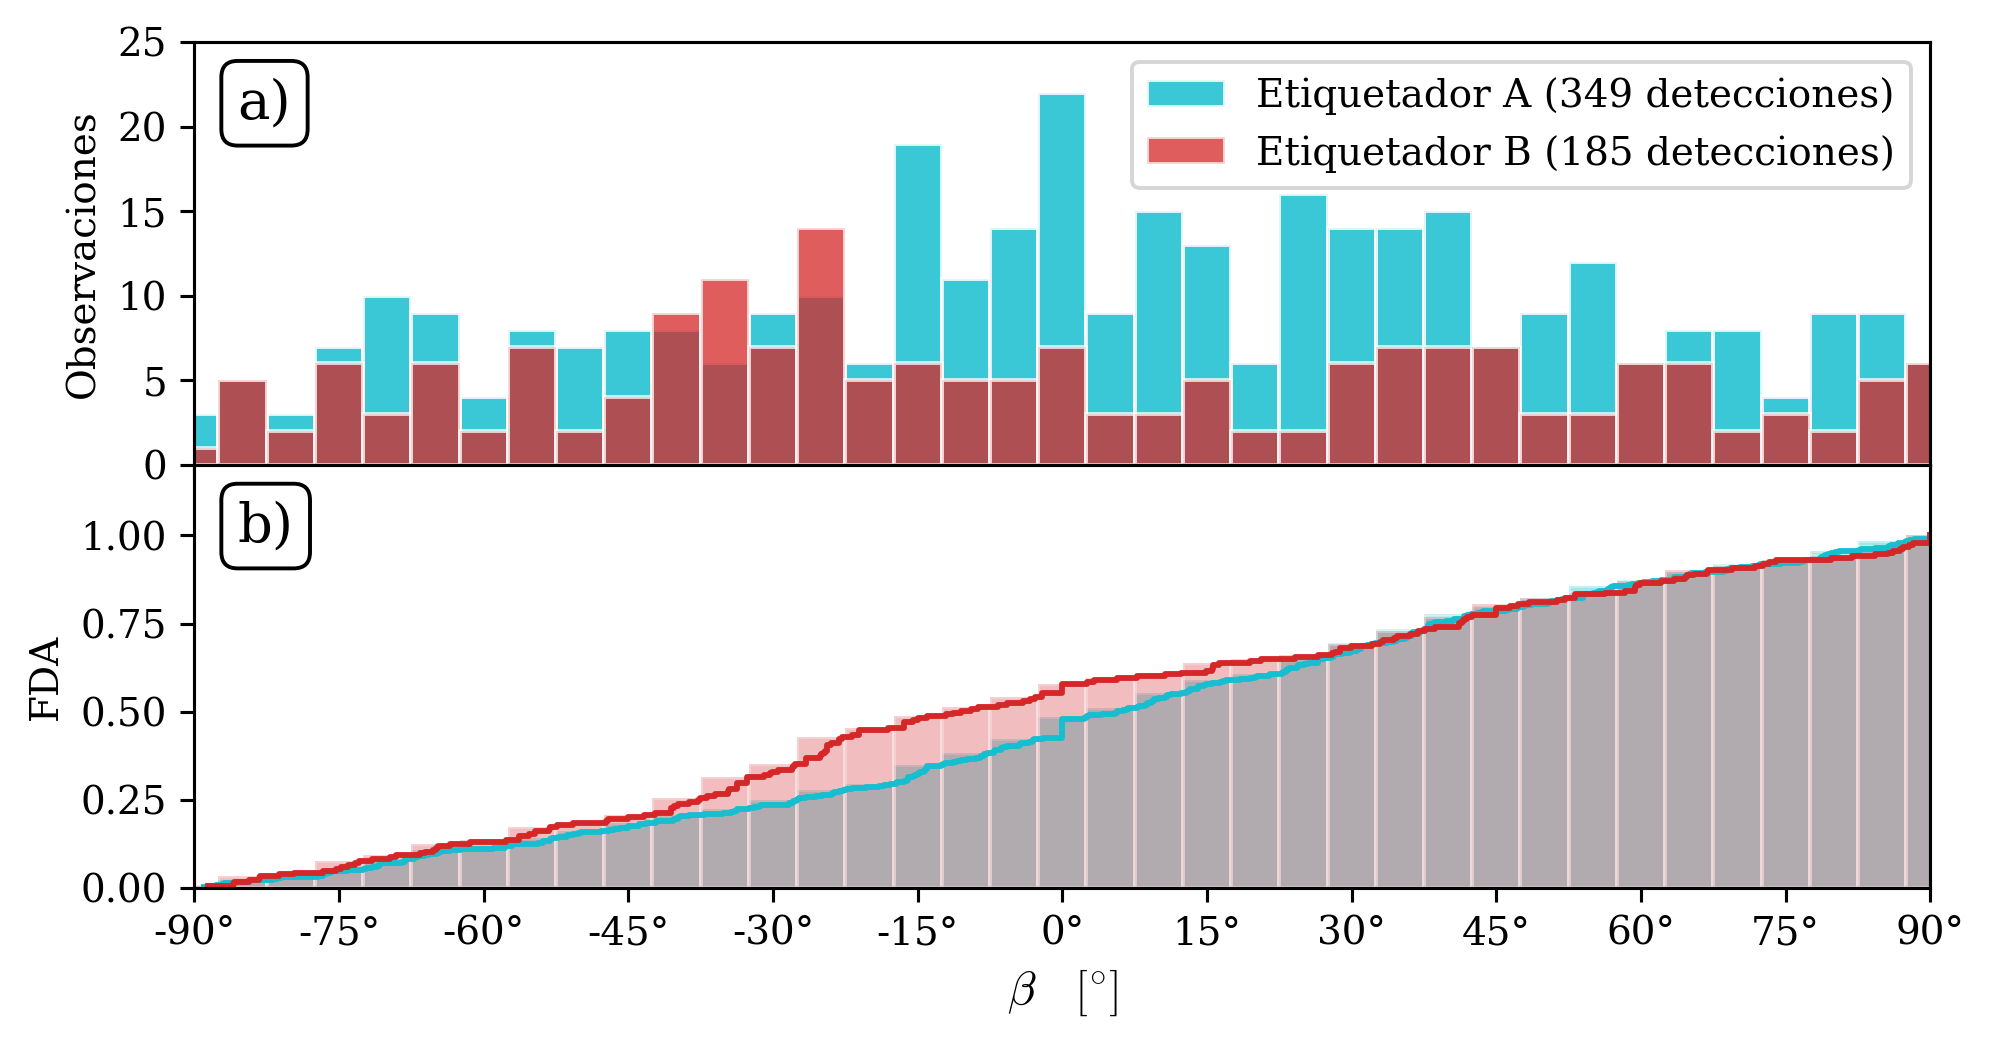

Resultados del test: KstestResult(statistic=0.1665453419035081, pvalue=0.0020831976049992943)


In [51]:
beta_bruno = np.concatenate(Betas[8:])*np.pi/180  # En radianes
beta_agus = np.concatenate(Betas[:8])*np.pi/180  # En radianes

beta_sorted_agus = np.sort(beta_agus)
cdf_agus = np.cumsum(beta_sorted_agus**0)/beta_agus.size

beta_sorted_bruno = np.sort(beta_bruno)
cdf_bruno = np.cumsum(beta_sorted_bruno**0)/beta_bruno.size

delta = 5*np.pi/180
edges = np.arange(np.pi/2, -np.pi/2 - 2*delta, -delta)[::-1] + delta/2
# Distribución
fig, axs = plt.subplots(2, 1, figsize=(8, 4.), dpi=140, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].hist(beta_agus, bins=edges, density=False, cumulative=False,
            color='C9', edgecolor='w', alpha=0.85,
            label=rf'Etiquetador A ({beta_agus.size} detecciones)',)
axs[0].hist(beta_bruno, bins=edges, density=False, cumulative=False,
            color='C3', edgecolor='w', alpha=0.75,
            label=rf'Etiquetador B ({beta_bruno.size} detecciones)',)
axs[0].legend(loc='upper right')
axs[0].text(0.025, 0.82, s='a)', fontsize=14, transform=axs[0].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
# axs[0].set_xticks([i*np.pi/12 for i in range(-6, 7)])
# axs[0].set_xticklabels([f'{i*15}°' for i in range(-6, 7)])
axs[0].set_ylim(top=25)
axs[0].set_ylabel('Observaciones', fontsize=10)


# Acumulativa
axs[1].hist(beta_agus, bins=edges, density=True, cumulative=True,
            color='C9', edgecolor='w', alpha=0.4)
axs[1].hist(beta_bruno, bins=edges, density=True, cumulative=True,
            color='C3', edgecolor='w', alpha=0.3)

plt.plot(beta_sorted_agus, cdf_agus, 'C9-', drawstyle='steps-post')
plt.plot(beta_sorted_bruno, cdf_bruno, 'C3-', drawstyle='steps-post')
# axs[1].legend(loc='upper left')
axs[1].text(0.025, 0.82, s='b)', fontsize=14, transform=axs[1].transAxes,
            bbox={'facecolor': 'white', 'boxstyle': 'round'}, zorder=15)
axs[1].set_xticks([i*np.pi/12 for i in range(-6, 7)])
axs[1].set_xticklabels([f'{i*15}°' for i in range(-6, 7)])
axs[1].set_xlim(-np.pi/2, np.pi/2)
axs[1].set_xlabel(r'$\beta \quad \mathrm{[^{\circ}]}$')
axs[1].set_ylim(top=1.2)
axs[1].set_ylabel('FDA', fontsize=10)

plt.show()

print('Resultados del test:', stats.ks_2samp(beta_agus, beta_bruno))

### Comparación mediciones por video

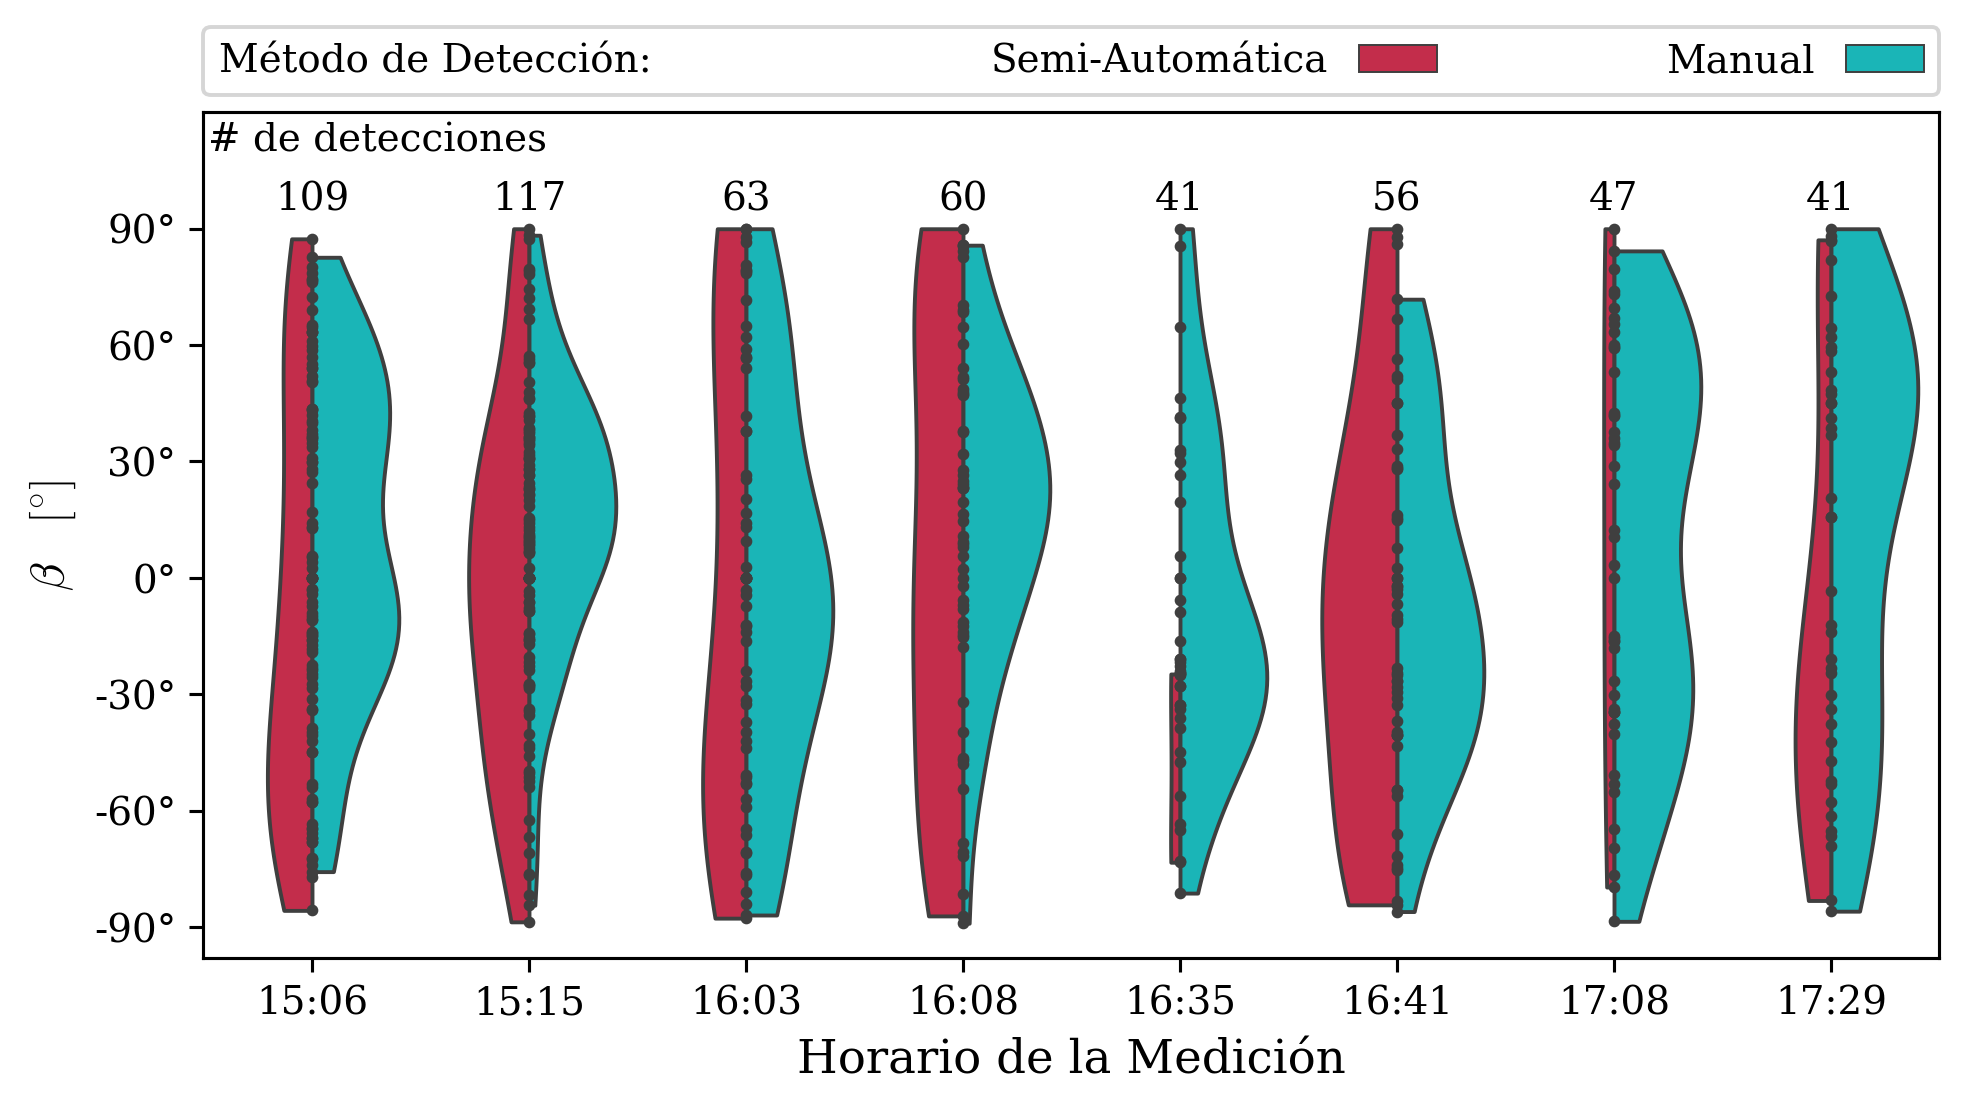

In [199]:
fig = plt.figure(figsize=(8, 4.), dpi=140)
ax = plt.subplot()
plt.plot([], [], ls='', label='Método de Detección:')  # solo para ponerle título a la leyenda
sns.violinplot(data=Mediciones, x="hora", y="beta", hue="metodo",
               split=True, inner="point", linewidth=1, scale='count', cut=0,
               palette=['crimson', 'darkturquoise'], ax=ax)
ax.text(0.3, 110*np.pi/180, '# de detecciones', ha='center')
for i, h in enumerate(Mediciones['hora'].unique()):
    ax.text(i, 95*np.pi/180, Mediciones['beta'][Mediciones['hora'] == h].count(),
            ha='center')
ax.legend(title='', loc='lower left', bbox_to_anchor=(0., 1.02, 1., .102),
          ncol=3, mode='expand', borderaxespad=0., markerfirst=False)
ax.set_yticks([i*np.pi/6 for i in range(-3, 4)])
ax.set_yticklabels([f'{i*30}°' for i in range(-3, 4)])
ax.set_ylim(top=120*np.pi/180)
ax.set_xlabel('Horario de la Medición')
ax.set_ylabel(r'$\beta \quad \mathrm{[^{\circ}]}$')
plt.show()